# CVXPY 1.4

https://cvxpy.org

CVXPY is an open source Python-embedded modeling language for convex optimization problems. It lets you express your problem in a natural way that follows the math, rather than in the restrictive standard form required by solvers.

    conda install -c conda-forge cvxpy

In [1]:
# To disable `warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)`
import warnings
warnings.filterwarnings('ignore')

### Example 8.17

Suppose that we wish to solve the least squares problem
$$
\min\|\mathbf{Ax}-\mathbf{b}\|^2 \quad\text{where}\quad
\mathbf{A} = \begin{bmatrix} 1 & 2 \\ 3 & 4 \\ 5 & 6 \end{bmatrix}, \quad
\mathbf{b} = \begin{bmatrix} 7 \\ 8 \\ 9 \end{bmatrix}. 
$$

In [2]:
import numpy as np
import cvxpy as cp

A = np.array([[1, 2], [3, 4], [5, 6]])
b = np.array([7, 8, 9])

x = cp.Variable(2)

objective = cp.Minimize(
    cp.sum_squares(A @ x - b)
)
prob = cp.Problem(objective)

prob.solve(), x.value

(1.8301573001127474e-28, array([-6. ,  6.5]))

In [3]:
objective = cp.Minimize(
    cp.norm(A @ x - b)**2
)

prob = cp.Problem(objective)
prob.solve(), x.value

(6.421847296963647e-19, array([-6. ,  6.5]))

In [4]:
objective = cp.Minimize(
    cp.quad_form(x, A.T @ A) - 2 * b @ A @ x # + b @ b
)

prob = cp.Problem(objective)
prob.solve(), x.value

(-194.00000000000003, array([-6. ,  6.5]))

### Example 8.18

Suppose that we wish to write a CVXPY code that solves the convex optimization problem
\begin{align*}
\text{minimize} &\quad \sqrt{x_1^2+x_2^2+1} + 2\max\{x_1,x_2,0\} \\
\text{subject to} &\quad |x_1|+|x_2|+\frac{x_1^2}{x_2} \leq 5 \\
&\quad \frac{1}{x_2} + x_1^4 \leq 10 \\
&\quad x_2 \geq 1, \quad x_1\geq 0.
\end{align*}

In [5]:
import numpy as np
import cvxpy as cp

x = cp.Variable(2)

objective = cp.Minimize(
    cp.norm(cp.hstack([x, 1])) + 2 * cp.max(cp.hstack([x, 0]))
)
constraints = [
    cp.norm(x, p=1) + cp.quad_over_lin(x[0], x[1]) <= 5,
    cp.inv_pos(x[1]) + x[0]**4 <= 10,
    x[1] >= 1, x[0] >= 0
]
prob = cp.Problem(objective, constraints)

prob.solve(), x.value

(3.4142135621977383, array([1.01942925e-06, 1.00000000e+00]))

### Example 8.19

Suppose that we wish to find the Chebyshev center of the five points
$$
(-1,3), \quad (-3,10), \quad (-1,0), \quad (5,0), \quad (-1,-5).
$$
Recall that the problem of finding the Chebyshev center of a set of points $\mathbf{a}_i$ for $1\leq i\leq m$ is given by (see Section 8.2.4)
\begin{align*}
\text{minimize} &\quad r \\
\text{subject to} &\quad \|\mathbf{x}-\mathbf{a}_i\| \leq r, \quad 1\leq i\leq m.
\end{align*}

In [6]:
import numpy as np
import cvxpy as cp

A = np.array([[-1, 3], [-3, 10], [-1, 0], [5, 0], [-1, -5]])

x = cp.Variable(2)
r = cp.Variable()

objective = cp.Minimize(r)
constraints = [
    cp.norm(x - a) <= r for a in A
]
prob = cp.Problem(objective, constraints)

prob.solve(), x.value, r.value

(7.566372968416897, array([-1.99996685,  2.50000442]), array(7.56637297))

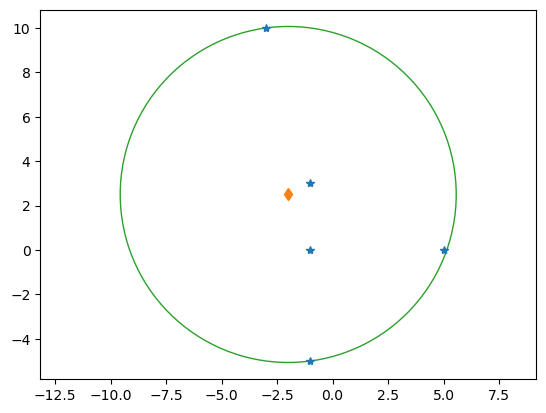

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

_, ax = plt.subplots()
ax.add_patch(
    Circle(x.value, r.value, color="C2", fill=False)
)
ax.plot(x.value[0], x.value[1], "d", color="C1")
ax.plot(A[:, 0], A[:, 1], "*", color="C0")
ax.axis("equal");

### Example 8.20 (robust regression)

Suppose that we are given 21 points in $\mathbb{R}^2$ generated by the commands

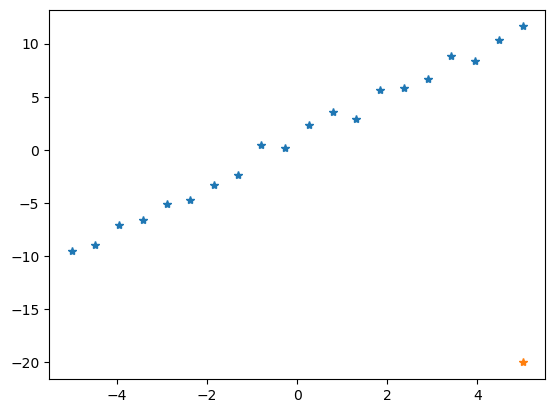

In [8]:
import numpy as np
import matplotlib.pyplot as plt

n = 20
x = np.linspace(-5, 5, num=n)
eps = np.sin(10 * np.arange(1, n+1) ** 3)
y = 2 * x + 1 + eps

x = np.hstack([x, 5])
y = np.hstack([y, -20])

_, ax = plt.subplots()
ax.plot(x[:-1], y[:-1], "*", color="C0") # randomly generated 20 points
ax.plot(x[-1], y[-1], "*", color="C1");  # (5, -20)

Note that the point $(5,-20)$ is an outlier; it is far away from all the other points and does not seem to fit into the almost-line structure of the other points.
The least squares line, also called the __regression line__, can be found by the commands

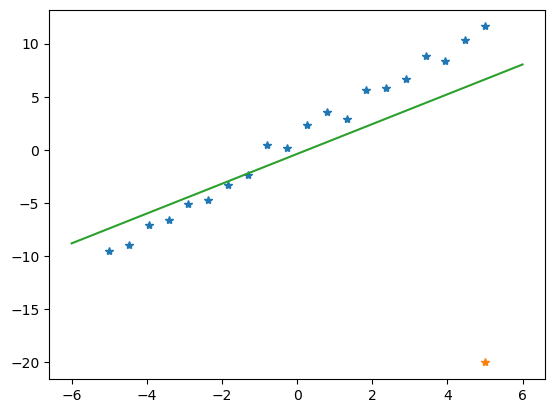

In [9]:
# We can rewrite the line equation $y = m x + c$
# as $y = Ap$, where $A = [[x, 1]]$ and $p = [[m], [c]]$.

A = np.hstack([x[:,np.newaxis], np.ones((x.shape[0],1))])
b = y

alpha, beta = np.linalg.lstsq(A, b)[0]
# print(alpha, beta)

_, ax = plt.subplots()
xlim = np.array([-6, 6])

ax.plot(x[:-1], y[:-1], "*", color="C0") # randomly generated 20 points
ax.plot(x[-1], y[-1], "*", color="C1")   # (5, -20)
ax.plot(xlim, alpha * xlim + beta, color="C2");

The least squares line is very much affected by the single outlier point, which is a known drawback of the least squares approach.

Another option is to replace the $l_2$-based objective $\|\mathbf{Ax}-\mathbf{b}\|_2^2$ with an $l_1$-based objective function; that is, we can consider the optimization problem $\min\|\mathbf{Ax}-\mathbf{b}\|_1$.

This approach has the advantage that it is less sensitive to outliers since outliers are not as severely penalized as they are penalized in the least squares objective function.
More specifically, in the least squares objective function, the distances to the line are squared, while in the $l_1$-based function they are not.

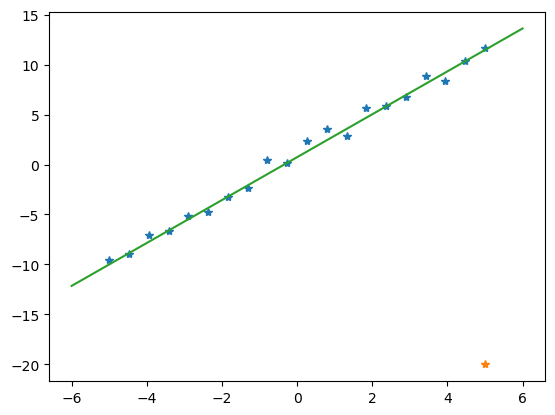

In [10]:
import cvxpy as cp

u = cp.Variable(2)

objective = cp.Minimize(
    cp.norm(A @ u - b, 1)
)
prob = cp.Problem(objective)

prob.solve()
alpha, beta = u.value
# print(alpha, beta)

_, ax = plt.subplots()
xlim = np.array([-6, 6])

ax.plot(x[:-1], y[:-1], "*", color="C0") # randomly generated 20 points
ax.plot(x[-1], y[-1], "*", color="C1")   # (5, -20)
ax.plot(xlim, alpha * xlim + beta, color="C2");

Note that the resulting line is insensitive to the outlier. This is why this line is also called the __robust regression line__.

### Example 8.21 (solution of a trust region subproblem)

There are several situations in which a certain problem is not convex but nonetheless can be recast as a convex optimization problem.
This situation is sometimes called "__hidden convexity__."

Consider the __trust region subproblem (TRS)__
\begin{align*}
\text{minimize} &\quad \mathbf{x}^T\mathbf{Ax} + 2\mathbf{b}^T\mathbf{x} \\
\text{subject to} &\quad \|\mathbf{x}\|^2 \leq 1,
\end{align*}
where $\mathbf{A} = \begin{bmatrix} 1 & 2 & 3 \\ 2 & 1 & 4 \\ 3 & 4 & 3 \end{bmatrix}$ and $\mathbf{b} = \begin{bmatrix} \frac{1}{2} \\ 1 \\ -\frac{1}{2} \end{bmatrix}$.

The problem is nonconvex since the matrix $\mathbf{A}$ is not positive semidefinite.

In [11]:
import numpy as np

A = np.array([[1, 2, 3], [2, 1, 4], [3, 4, 3]])
b = 0.5 * np.array([1, 2, -1])

# numpy.linalg.eigh(A) returns a namedtuple with
#   eigenvalues: ndarray of shape (M,)
#   eigenvectors: ndarray of shape (M, M)
#     The column `eigenvectors[:, i]` is the normalized eigenvector
#     corresponding to the eigenvalue `eigenvalues[i]`.
d, U = np.linalg.eigh(A)
d

array([-2.1683478 , -0.80932486,  7.97767266])

It is therefore not possible to solve the problem directly using CVXPY.
Instead, we will use the technique described in Section 8.2.7 to convert the problem into a convex problem, and then we will be able to solve the transformed problem via CVXPY.

1. By the spectral decomposition theorem, there exist an orthogonal matrix $\mathbf{U}$ and a diagonal matrix $\mathbf{D}=\operatorname{diag}(d_1,d_2,\dotsc,d_n)$ such that $\mathbf{A}=\mathbf{UDU}^T$, and hence (TRS) can be rewritten as
$$
\min\{ \mathbf{x}^T\mathbf{UDU}^T\mathbf{x} + 2\mathbf{b}^T\mathbf{UU}^T\mathbf{x} + c \mid \|\mathbf{U}^T\mathbf{x}\|^2\leq 1 \}. \tag{8.11}
$$

2. Making the linear change of variables $\mathbf{y}=\mathbf{U}^T\mathbf{x}$, it follows that (8.11) reduces to
$$
\min\{ \mathbf{y}^T\mathbf{Dy} + 2\mathbf{b}^T\mathbf{Uy} + c \mid \|\mathbf{y}\|^2\leq 1 \}.
$$

3. Denoting $\mathbf{f}=\mathbf{U}^T\mathbf{b}$, we obtain the following formulation of the problem:
\begin{align*}
\text{minimize} &\quad \sum_i d_i y_i^2 + 2\sum_i f_i y_i + c \\
\text{subject to} &\quad \sum_i y_i^2 \leq 1.
\end{align*} \tag{8.12}

The problem is still nonconvex since some of the $d_i$ s might be negative.

__Lemma 8.7__ Let $\mathbf{y}^*$ be an optimal solution of (8.12). Then $f_i y_i^*\leq 0$ for all $i$.

As a direct result of Lemma 8.7 we have that for any optimal solution $\mathbf{y}^*$, the equality $\operatorname{sgn}(y_i^*)=-\operatorname{sgn}(f_i)$ holds when $f_i\neq 0$.
When $f_i=0$, the sign of $\mathbf{y}^*$ can be chosen arbitrarily.

As a consequence, we can make the change of variables $y_i=-\operatorname{sgn}(f_i)\sqrt{z_i}$, and problem (8.12) becomes
\begin{align*}
\text{minimize} &\quad \sum_i d_i z_i - 2\sum_i |f_i|\sqrt{z_i} + c \\
\text{subject to} &\quad \sum_i z_i \leq 1 \\
&\quad z_i\geq 0 \quad\text{for all $i$}.
\end{align*}

Obviously this is a convex optimization problem since the constrains are linear and the objective function is a sum of linear terms and positive multiples of the convex functions.

In [12]:
import cvxpy as cp

f = U.T @ b

z = cp.Variable(3)
objective = cp.Minimize(
    d.T @ z - 2 * np.abs(f).T @ cp.sqrt(z)
)
constraints = [cp.sum(z) <= 1, z >= 0]
prob = cp.Problem(objective, constraints)

prob.solve()

-4.480614246579162

The optimal solution is then computed by $y_i=-\operatorname{sgn}(f_i)\sqrt{z_i}$ and then $\mathbf{x}=\mathbf{Uy}$.

In [13]:
y = -np.sign(f) * np.sqrt(z.value)
x = U @ y
x

array([-0.23004067, -0.72589557,  0.64819512])